# Description

This script generates a data pattern for use in a Representational Similarity Analysis (RSA) aimed at estimating the similarity or dissimilarity between different emotion morph levels. The process involves running a General Linear Model (GLM), with each morph level assigned its own regressor. Due to computational constraints, the GLMs are focused on specific Regions of Interest (ROIs), specifically the Amygdala. A contrast is computed between each regressor and the baseline, and the resulting beta values serve as input data for the similarity and dissimilarity analysis.


# Load packages

In [4]:
from nilearn import image, masking, plotting, datasets
from nilearn.glm.first_level import FirstLevelModel
import nibabel as nib
from scipy.io import loadmat
import os
import json
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.covariance import ledoit_wolf
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [5]:
# FUNCTIONS: 
def create_mask(roi_name, atlas, func_img, show_mask = False):
    
    print(f'Creating mask for {roi_name}')
    
    #load mask:
    roi_mask = image.index_img(atlas['maps'], atlas['labels'].index(roi_name)-1) # background in label list but has no mask

    #threshold mask:
    roi_mask_thres = image.threshold_img(roi_mask, 25) #25% probability 

    #resample to correct for flipping and align the two voxel grids - world coordinates (last col on the right) do not match 
    #to see that call func.affine and roi_mask.affine
    roi_mask_resamp = image.resample_img(roi_mask_thres, 
                                         target_affine=func_img.affine, 
                                         target_shape=func_img.shape[:3],
                                         interpolation="nearest")
    
    roi_mask_binary = image.math_img("img>0", img=roi_mask_resamp)

    if show_mask:
        display = plotting.plot_roi(roi_mask_binary, cmap="autumn", vmin=0, title=roi_name)
        
    return roi_name, roi_mask_binary


def create_betas_pattern(sub, task, func_img, t_r, slice_time_ref, mask_img_name, mask_img, events, realignment_params, #for running glm
                         cut_factor=2, hrf_model="glover", noise_model="ols", drift_model="cosine", high_pass=0.01, #for running glm
                         num_condition=0, stat_type="t", output_type="effect_size", # for computing contrast
                         output_home_dir="/home/td/fMRI_internship/derivatives-ni-edu-env", save_residuals=True):
    
    # first level model
    flm = FirstLevelModel(t_r=t_r, slice_time_ref=slice_time_ref, 
                          mask_img=mask_img, hrf_model=hrf_model,
                          noise_model=noise_model, drift_model=drift_model, 
                          high_pass=high_pass, minimize_memory=False)
    
    # run for only half of the data
    cut_func = round(func_img.shape[-1]/cut_factor)
    cut_event = int(len(events)/cut_factor)
    
    # run model 
    flm.fit(run_imgs=image.index_img(func_img, np.arange(0, cut_func)),
            events=events.iloc[:cut_event, :], 
            confounds=realignment_params.iloc[:cut_func, :])
    
    # unload memory:
    func_img = None
    
    # create pattern 
    flm_dm = flm.design_matrices_[0]
    
    print(f'Creating pattern for {mask_img_name}')
    
    R_list = []
    
    print(flm_dm.columns[:num_condition])
    for trial in flm_dm.columns[:num_condition]:
        
        contrast = flm.compute_contrast(trial, stat_type=stat_type, output_type=output_type) # each trial aginst baseline 
        masked = masking.apply_mask(contrast, mask_img)
        R_list.append(masked)
    
    R = np.vstack(R_list)
    residuals = flm.residuals[0]
    
    return R, residuals
      
def multivariate_noise_normalize(R, mask_img, residuals):

    # multivariate noise normalization:
    resids = masking.apply_mask(residuals, mask_img)
    
    print(resids.shape)
    noise_cov = ledoit_wolf(resids)[0]
    D = sqrtm(np.linalg.inv(noise_cov))
    R_mnn = R @ D
    
    return R_mnn

In [6]:
# PATH # 
workflow_name = 'spm_preproc1'
base_path = f"/home/td/fMRI_internship/derivatives/datasink/{workflow_name}"

# SUBJECT AND TASK #
subject_list = ['sub-01', 'sub-06']
task_list = ['task-emodet']

# Choose subject and task 
sub = subject_list[0]
task = task_list[0]

# LOAD ONSETS #
onsets_file_path = os.path.join('/home/td/fMRI_internship/raw/', sub, 'func', f'{sub}_{task}_onsets.mat')
onsets_data = loadmat(onsets_file_path)

# create df with all trial types and their onsets
events_df = pd.DataFrame(columns=['onset', 'duration', 'trial_type'])

onset = []
trial_type = []

for i, name in enumerate(n[0] for n in onsets_data['names'][0] if "morph" in n[0]):
    current_onset = onsets_data['onsets'][0][i].squeeze()
    onset.extend(current_onset)
    trial_type.extend([name]*len(current_onset))

events_df['onset']=onset
events_df['duration']=1
events_df['trial_type']=trial_type
events_df

events_df = events_df.sort_values(by="onset", ascending=True).reset_index(drop=True)
    
# LOAD OTHER INFOS:
json_path = f'/home/td/fMRI_internship/raw/{sub}/func/{sub}_{task}_bold.json'
with open(json_path, 'r') as file:
    content = file.read()
    json_data = json.loads(content)
    
t_r = json_data['RepetitionTime']
slice_time_ref = 0.25 #due to Multibandsequenz #no further slice timing is done, only used to define start and end time point.

### load realignment parameter to use as confounds ###
realignment_params_path = os.path.join(base_path, sub, task, f'rp_a{sub}_{task}_bold_roi.txt')
realignment_params = np.loadtxt(realignment_params_path)
realignment_params_df = pd.DataFrame(data=realignment_params, columns=["x", "y", "z", "pitch", "roll", "yaw"])
# columns 1-3 represent x, y and z translations in mm, while columns 4-6 correspond to pitch, roll and yaw rotations in radians.

# LOAD ATLAS FOR MASKING:  Harvard-Oxford atlas - PROBABILITY 
"""
There are two primary types of atlas images in FSL:

A probabilistic atlas is a 4D NIFTI image, where each 3D volume contains a probability map for one region in the atlas. 
Each 3D volum contains values between 0 and 100, indicating the probability that a given voxel is classified as belonging
to the structure represented by that volume. A label (or summary, or hard segementation) atlas is a 3D NIfTI image which 
contains different discrete integer values for each region defined in the atlas.
"""
ho_cort_prob_atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
ho_cort_prob_atlas_img = image.load_img(ho_cort_prob_atlas['maps'])
# display = plotting.plot_prob_atlas(ho_cort_prob_atlas_img, colorbar=True)#, threshold="90%")

ho_sub_prob_atlas = datasets.fetch_atlas_harvard_oxford('sub-prob-2mm')
ho_sub_prob_atlas_img = image.load_img(ho_sub_prob_atlas['maps'])
# display = plotting.plot_prob_atlas(ho_sub_prob_atlas_img, colorbar=True)#, threshold="90%")

rois_cort_list = ["Inferior Frontal Gyrus, pars triangularis", # anterior
             "Inferior Frontal Gyrus, pars opercularis", # posterior 
             "Insular Cortex",
             "Cingulate Gyrus, anterior division",
             "Cingulate Gyrus, posterior division",
             "Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)",
                "Frontal Medial Cortex"
            ]

rois_sub_list = ['Right Amygdala', 'Left Amygdala']


In [ ]:
# create dissimilarity matrix
roi_name = "Right Amygdala"
func = image.load_img(f"{base_path}/{sub}/{task}/fwhm-4swra{sub}_{task}_bold_roi.nii") # smooth can also be done in FirstLevelModel
mask_img_name, mask_img = create_mask(roi_name, atlas=ho_sub_prob_atlas, func_img=func, show_mask = True)

# run glm and create pattern 
R, residuals = create_betas_pattern(sub, task, func_img=func, t_r=t_r, slice_time_ref=slice_time_ref,
                     mask_img_name=mask_img_name, mask_img=mask_img, events=events_df,
                     realignment_params=realignment_params_df, cut_factor=2,
                     hrf_model="glover", noise_model="ols", drift_model="cosine", high_pass=0.01,
                     num_condition=5, stat_type="t", output_type="effect_size",
                     output_home_dir="/home/td/fMRI_internship/derivatives-ni-edu-env", save_residuals=True)

R_mnn = multivariate_noise_normalize(R, mask_img=mask_img, residuals=residuals)

#calculate dissimilarity 
rdm = pairwise_distances(R, metric='cosine')

#save dissimilarity matrix
np.save(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/rdm_{mask_img_name}", rdm)

# Inspect RDM 

It's recommended to restart kernel and then inspect the rdm if kernel die.

In [12]:
# load rdm 
mask_img_name="Right Amygdala"
rdm = np.load(f"/home/td/fMRI_internship/derivatives-ni-edu-env/{sub}/{task}/rdm_{mask_img_name}.npy")

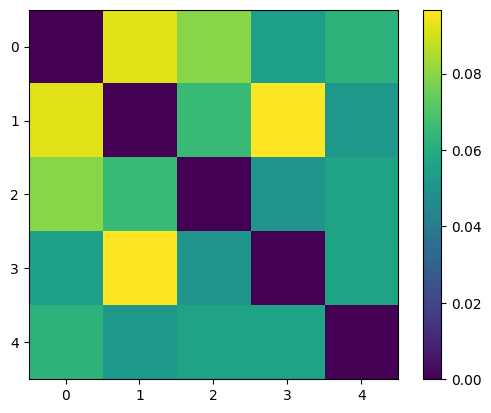

In [13]:
# visualize rdm
plt.imshow(rdm)
plt.colorbar()

# 0 - 'morph_0_100'
# 1 - 'morph_20_80'
# 2 - 'morph_40_60'
# 3 - 'morph_45_55'
# 4 - 'morph_50_50'